In [2]:
import torch


torch.cuda.is_available()

/home/ctq566/miniconda3/envs/mdm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Latent Space Visualization
It is intended to do something similar to [Visualization and understanding of latent space #12](https://github.com/ChenFengYe/motion-latent-diffusion/issues/12), but for MDM.

We take `./assets/direction_number_text_prompts_64.txt` as input, where we have 64 prompts and the repetition is 10.

Since `ClassifierFreeSampleModel` is used, we have both conditioned and unconditioned samples. The `diffusion_steps` is 1000, so we would have 2000 samples for each prompt each repetition. Since the number of samples is too large, we only take the latent vector of step 0, 250, 500, 750, and 999.

Each `.npy` file contains 64 latent vectors (since we have 64 prompts). They all have names like this `latent_vec_<diffusion_step>_<index>`. If the `index` is even, it means the latent vector is conditioned, otherwise it is unconditioned.

For example, `latent_vec_0_0.npy` is the latent vector of the first prompt at step 0, and it is conditioned.

We are going to make this notebook more general, so that we can use it for other inputs.

In [3]:
# !pip install pandas

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def load_data(timesteps, repetitions, latent_vec_path='../latent_vec/latent_vec_64/'):
    data_conditioned = []
    data_unconditioned = []
    for i in range(repetitions):
        data_conditioned.append(np.load(os.path.join(latent_vec_path, f'latent_vec_{timesteps}_{2 * i}.npy')))
        data_unconditioned.append(np.load(os.path.join(latent_vec_path, f'latent_vec_{timesteps}_{2 * i + 1}.npy')))
    return np.array(data_conditioned), np.array(data_unconditioned)


def preprocess_data(data, repeitions, classes):
    data = data.transpose((0, 2, 1, 3)).reshape((repeitions * classes, -1, 512))
    data = data.reshape((repeitions * classes, -1))
    return data


def draw_tsne(data, labels, colors, markers, title='', output_dir='../assets/pdf/latent_vec_64', fig=None, ax=None):
    np.random.seed(42)
    plt.figure(figsize=(10, 10))
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1000)
    X_2d = tsne.fit_transform(data)
    for i in range(len(labels)):
        plt.scatter(X_2d[i::len(labels), 0], X_2d[i::len(labels), 1], c=colors[i // len(markers)], marker=markers[i % len(markers)], label=labels[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join([output_dir, f'{title}.pdf']), bbox_inches='tight')


In [5]:


# for timestep in timesteps:
#     data_conditioned, data_unconditioned = load_data(timestep, repeitions)
#     data_conditioned = preprocess_data(data_conditioned, repeitions, classes)    
#     draw_tsne(data_conditioned, prompts, colors, markers, title=f'Conditioned at timestep {timestep}')
#     data_unconditioned = preprocess_data(data_unconditioned, repeitions, classes)
#     draw_tsne(data_unconditioned, prompts, colors, markers, title=f'Unconditioned at timestep {timestep}')


/home/ctq566/miniconda3/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ctq566/miniconda3/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/ctq566/miniconda3/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ctq566/miniconda3/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/ctq566/miniconda3/envs/mdm/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  Future

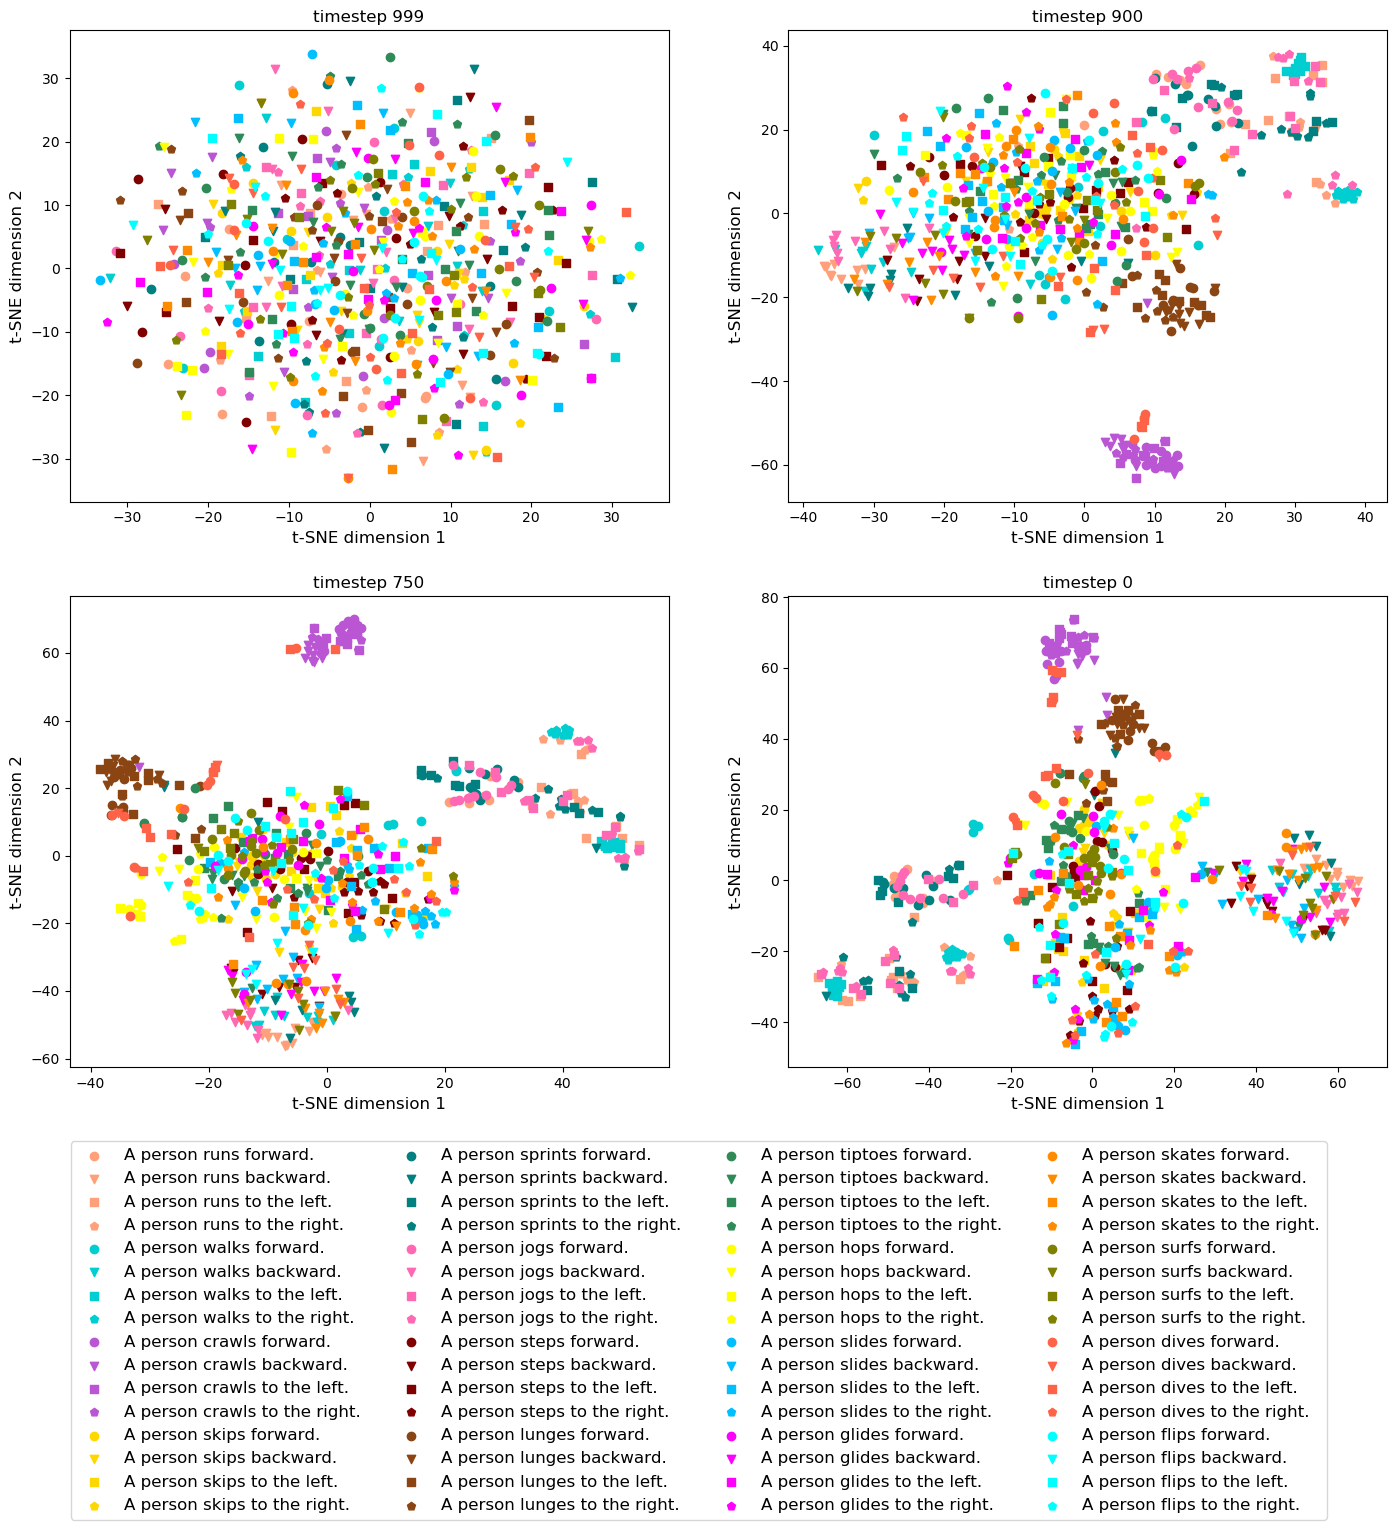

In [10]:
classes = 64
repeitions = 10

with open('../assets/texts/direction_number_text_prompts_64.txt', 'r') as f:
    prompts = f.readlines()
    prompts = [p.strip() for p in prompts]

timesteps = list(range(0, 999, 50))
timesteps.append(999)

# Draw 16 different colors and 4 different markers
colors = ['#FFA07A', '#00CED1', '#BA55D3', '#FFD700',
          '#008080', '#FF69B4', '#800000', '#8B4513',
          '#2E8B57', '#FFFF00', '#00BFFF', '#FF00FF',
          '#FF8C00', '#808000', '#FF6347', '#00FFFF']
markers = ['o', 'v', 's', 'p']

fig, axs = plt.subplots(2, 2, figsize=(17, 17))
axs = axs.flatten()

for idx, time_step in enumerate([999, 900, 750, 0]):
    np.random.seed(42)
    tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1000)

    data, _ = load_data(time_step, repeitions)
    data = preprocess_data(data, repeitions, classes)
    X_2d = tsne.fit_transform(data)
    for i in range(len(prompts)):
        axs[idx].scatter(X_2d[i::len(prompts), 0], X_2d[i::len(prompts), 1], c=colors[i // len(markers)], marker=markers[i % len(markers)], label=prompts[i])
    axs[idx].set_title(f'timestep {time_step}')
    axs[idx].set_xlabel('t-SNE dimension 1', fontsize=12)
    axs[idx].set_ylabel('t-SNE dimension 2', fontsize=12)

# Adjust the spacing between the subplots and the legend
fig.subplots_adjust(bottom=0.27)
# fig.text(0.1, 0.4, 't-SNE dimension 2', va='center', rotation='vertical', fontsize=12)
# fig.text(0.1, 0.75, 't-SNE dimension 2', va='center', rotation='vertical', fontsize=12)

# Place the legend below the subplots
fig.legend(loc='lower center', ncol=4, labels=prompts, fontsize=12)

output_dir='../assets/pdf/latent_vec_64'
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, f'latent_vec_64.pdf'), bbox_inches='tight')
